In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import folium
from folium import plugins 
from folium.plugins import HeatMap
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [199]:
merged_data = pd.read_csv("/Users/Admin/Desktop/Elon-Musk-Cryptocurrency-Influence/data_processing/merged_data/final_merged_dataset_btc.csv")
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['log_return'] = np.log(merged_data['close'] / merged_data['close'].shift(48))

merged_data = merged_data.dropna()
merged_data.head()

,SENDER,MESSAGE,date,sentiment_score,sentiment,is_crypto_related,symbol,open,high,low,close,log_return
48,-1001153434921,per min argue knight min bulk discount elon mu...,2018-11-15 20:00:00,0.000000,Neutral,False,BTC/USD,5543.30,5548.43,5472.05,5475.75,-0.176283
49,-1001153434921,looking back sun upper stage falcon landed dro...,2018-11-15 21:00:00,0.166667,Positive,False,BTC/USD,5475.75,5476.66,5414.14,5466.77,-0.211312
50,-1001153434921,sure hope isnt true nonlinearities siberian pe...,2018-11-16 16:00:00,0.087500,Positive,False,BTC/USD,5534.63,5559.99,5527.80,5549.98,-0.190265
51,-1001153434921,haha elon musk november,2018-11-16 16:00:00,0.200000,Positive,False,BTC/USD,5534.63,5559.99,5527.80,5549.98,-0.190265
52,-1001153434921,china especially amazing job moving towards su...,2018-11-16 16:00:00,1.000000,Positive,False,BTC/USD,5534.63,5559.99,5527.80,5549.98,-0.190265


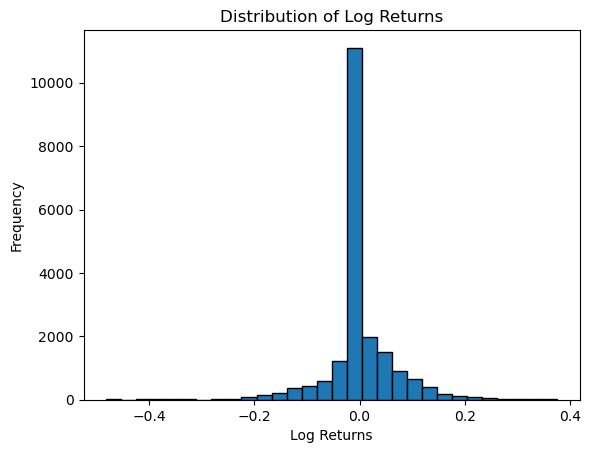

In [200]:
import matplotlib.pyplot as plt

log_returns = merged_data['log_return']

plt.hist(log_returns, bins=30, edgecolor='black')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Log Returns')
plt.show()


In [201]:
grouped_data = merged_data.groupby('SENDER')
grouped_data.head()

# Mean Bitcoin before and after
hours_before = 48 
hours_after = 48  

mean_prices = []
dates = []

for sender, data in grouped_data:
    tweet_dates = data['date']
    for tweet_date in tweet_dates:
        start_time = tweet_date - pd.Timedelta(hours=hours_before)
        end_time = tweet_date + pd.Timedelta(hours=hours_after)
        prices_before = data[(data['date'] >= start_time) & (data['date'] < tweet_date)]['close']
        prices_after = data[(data['date'] > tweet_date) & (data['date'] <= end_time)]['close']
        mean_before = prices_before.mean()
        mean_after = prices_after.mean()
        mean_prices.append(mean_after - mean_before)
        dates.append(tweet_date)

# new result df
result_df = pd.DataFrame({'date': dates, 'price_change': mean_prices})

# defining threshold for the price movement
threshold = 2500
significant_changes = result_df[abs(result_df['price_change']) > threshold]

# falls and jumps
price_jumps = significant_changes[significant_changes['price_change'] > 0]
price_falls = significant_changes[significant_changes['price_change'] < 0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=price_jumps['date'], y=price_jumps['price_change'],
                         mode='markers', marker=dict(color='green'), name='Price jump'))
fig.add_trace(go.Scatter(x=price_falls['date'], y=price_falls['price_change'],
                         mode='markers', marker=dict(color='red'), name='Price fall'))
fig.update_layout(title='Bitcoins price movement after Elon Musks Tweets',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Price Movement'))
fig.show()


In [204]:
from math import ceil, sqrt

def movmean(v, kb, kf):
    """
    Computes the mean with a window of length kb+kf+1 that includes the element 
    in the current position, kb elements backward, and kf elements forward.
    Nonexisting elements at the edges get substituted with NaN.
    Args:
        v (list(float)): List of values.
        kb (int): Number of elements to include before current position
        kf (int): Number of elements to include after current position
    Returns:
        list(float): List of the same size as v containing the mean values
    """
    m = len(v) * [np.nan]
    for i in range(kb, len(v)-kf):
        m[i] = np.mean(v[i-kb:i+kf+1])
    return m


def LeeMykland(S, sampling, significance_level=0.1):
    """
    "Jumps in Equilibrium Prices and Market Microstructure Noise"
    - by Suzanne S. Lee and Per A. Mykland
    
    "https://galton.uchicago.edu/~mykland/paperlinks/LeeMykland-2535.pdf"
    
    Args:
        S (list(float)): An array containing prices, where each entry 
                         corresponds to the price sampled every 'sampling' minutes.
        sampling (int): Minutes between entries in S
        significance_level (float): Defaults to 1% (0.001)
        
    Returns:
        A pandas dataframe containing a row covering the interval 
        [t_i, t_i+sampling] containing the following values:
        J:   Binary value is jump with direction (sign)
        L:   L statistics
        T:   Test statistics
        sig: Volatility estimate
    """
    tm = 252*24*60 # Trading minutes
    k   = ceil(sqrt(tm/sampling))
    r = np.append(np.nan, np.diff(np.log(S)))
    bpv = np.multiply(np.absolute(r[:]), np.absolute(np.append(np.nan, r[:-1])))
    bpv = np.append(np.nan, bpv[0:-1]).reshape(-1,1) # Realized bipower variation
    sig = np.sqrt(movmean(bpv, k-3, 0)) # Volatility estimate
    L   = r/sig
    n   = np.size(S) # Length of S
    c   = (2/np.pi)**0.5
    Sn  = c*(2*np.log(n))**0.5
    Cn  = (2*np.log(n))**0.5/c - np.log(np.pi*np.log(n))/(2*c*(2*np.log(n))**0.5)
    beta_star   = -np.log(-np.log(1-significance_level)) # Jump threshold
    T   = (abs(L)-Cn)*Sn
    J   = (T > beta_star).astype(float)
    J   = J*np.sign(r) # Add direction
    # First k rows are NaN involved in bipower variation estimation are set to NaN.
    J[0:k] = np.nan
    # Build and return result dataframe
    return pd.DataFrame({'L': L,'sig': sig, 'T': T,'J':J})


prices = merged_data['open'].tolist()

sampling = 60 

result = LeeMykland(prices, sampling)

merged_data = pd.concat([merged_data, result], axis=1)

merged_data.head()


/var/folders/49/1bqwbw2539j4jwl3zcbb_hb00000gn/T/ipykernel_56798/1813734440.py:48: RuntimeWarning:

invalid value encountered in true_divide



,SENDER,MESSAGE,date,sentiment_score,sentiment,is_crypto_related,symbol,open,high,low,close,log_return,L,sig,T,J
48,-1.001153e+12,per min argue knight min bulk discount elon mu...,2018-11-15 20:00:00,0.000000,Neutral,False,BTC/USD,5543.30,5548.43,5472.05,5475.75,-0.176283,NaN,NaN,NaN,NaN
49,-1.001153e+12,looking back sun upper stage falcon landed dro...,2018-11-15 21:00:00,0.166667,Positive,False,BTC/USD,5475.75,5476.66,5414.14,5466.77,-0.211312,NaN,NaN,NaN,NaN
50,-1.001153e+12,sure hope isnt true nonlinearities siberian pe...,2018-11-16 16:00:00,0.087500,Positive,False,BTC/USD,5534.63,5559.99,5527.80,5549.98,-0.190265,NaN,NaN,NaN,NaN
51,-1.001153e+12,haha elon musk november,2018-11-16 16:00:00,0.200000,Positive,False,BTC/USD,5534.63,5559.99,5527.80,5549.98,-0.190265,NaN,NaN,NaN,NaN
52,-1.001153e+12,china especially amazing job moving towards su...,2018-11-16 16:00:00,1.000000,Positive,False,BTC/USD,5534.63,5559.99,5527.80,5549.98,-0.190265,NaN,NaN,NaN,NaN


In [205]:
merged_data.head(555)

,SENDER,MESSAGE,date,sentiment_score,sentiment,is_crypto_related,symbol,open,high,low,close,log_return,L,sig,T,J
48,-1.001153e+12,per min argue knight min bulk discount elon mu...,2018-11-15 20:00:00,0.000000,Neutral,False,BTC/USD,5543.30,5548.43,5472.05,5475.75,-0.176283,NaN,NaN,NaN,NaN
49,-1.001153e+12,looking back sun upper stage falcon landed dro...,2018-11-15 21:00:00,0.166667,Positive,False,BTC/USD,5475.75,5476.66,5414.14,5466.77,-0.211312,NaN,NaN,NaN,NaN
50,-1.001153e+12,sure hope isnt true nonlinearities siberian pe...,2018-11-16 16:00:00,0.087500,Positive,False,BTC/USD,5534.63,5559.99,5527.80,5549.98,-0.190265,NaN,NaN,NaN,NaN
51,-1.001153e+12,haha elon musk november,2018-11-16 16:00:00,0.200000,Positive,False,BTC/USD,5534.63,5559.99,5527.80,5549.98,-0.190265,NaN,NaN,NaN,NaN
52,-1.001153e+12,china especially amazing job moving towards su...,2018-11-16 16:00:00,1.000000,Positive,False,BTC/USD,5534.63,5559.99,5527.80,5549.98,-0.190265,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,-1.001153e+12,heard mph wind broke mooring block late last n...,2019-01-23 15:00:00,-0.150000,Negative,False,BTC/USD,3568.75,3575.42,3551.82,3552.62,0.013712,1.038754,0.002657,-14.425992,0.0
599,-1.001153e+12,actual tank fine elon musk january,2019-01-23 16:00:00,0.208333,Positive,False,BTC/USD,3552.62,3574.52,3552.62,3572.43,0.019272,2.465959,0.002676,-9.354173,0.0
600,-1.001153e+12,sweden ban sale gasoline diesel car germany la...,2019-01-23 20:00:00,-0.400000,Negative,False,BTC/USD,3535.00,3554.28,3518.00,3535.79,0.009371,0.599659,0.002720,-15.986391,0.0
601,-1.001153e+12,dont afraid hard work nothing worthwhile come ...,2019-01-23 20:00:00,0.010417,Positive,False,BTC/USD,3535.00,3554.28,3518.00,3535.79,0.009371,0.272852,0.002746,-17.147756,0.0


In [206]:
#filtered_df = merged_data[merged_data['J'] == 1]
filtered_df = merged_data[(merged_data['J'] == -1) | (merged_data['J'] == 1)]

filtered_df.head()

,SENDER,MESSAGE,date,sentiment_score,sentiment,is_crypto_related,symbol,open,high,low,close,log_return,L,sig,T,J
78,-1.001153e+12,perhaps year elon musk november,2018-11-19 15:00:00,0.0,Neutral,False,BTC/USD,5097.93,5160.99,5071.58,5110.85,-0.066017,9.117252,0.008822,14.282352,1.0
79,-1.001153e+12,ok elon musk november,2018-11-19 20:00:00,0.5,Positive,False,BTC/USD,4949.16,5033.73,4861.23,4881.12,-0.119099,5.906351,0.008724,2.871858,1.0
109,-1.001153e+12,trouble elon musk november,2018-11-26 03:00:00,-0.2,Negative,False,BTC/USD,3963.65,4000.61,3944.96,3981.30,-0.320799,6.041353,0.011748,3.351610,1.0
153,-1.001153e+12,elon musk november,2018-11-30 20:00:00,0.0,Neutral,False,BTC/USD,3969.62,3979.63,3939.82,3950.00,-0.000964,-7.758647,0.010172,9.454313,-1.0
170,-1.001153e+12,glad youre ok elon musk december,2018-12-01 22:00:00,0.5,Positive,False,BTC/USD,4174.90,4196.20,4153.00,4174.28,0.122503,5.801893,0.007778,2.500648,1.0


In [207]:
#final_df = filtered_df[(filtered_df['is_crypto_related'] == True) & (filtered_df['J'] == 1)]
final_df = filtered_df[(filtered_df['is_crypto_related'] == True)]
final_df.head()

,SENDER,MESSAGE,date,sentiment_score,sentiment,is_crypto_related,symbol,open,high,low,close,log_return,L,sig,T,J
7431,-1.001153e+12,bitcoin safe word elon musk december,2020-12-20 08:00:00,0.5,Positive,True,BTC/USD,23634.23,23799.80,23546.47,23694.78,0.251195,6.309968,0.006713,4.306179,1.0
7439,-1.001153e+12,bitcoin almost b fiat money elon musk december,2020-12-20 10:00:00,0.0,Neutral,True,BTC/USD,23593.07,23652.70,23369.18,23411.47,0.236084,6.024136,0.006930,3.290428,1.0
8548,-1.001153e+12,hey cryptocurrency expert ever heard paypal po...,2021-05-16 18:00:00,0.0,Neutral,True,BTC/USD,47108.64,47401.00,45378.00,45407.65,-0.254196,-8.330212,0.016753,11.485469,-1.0
8684,-1.001153e+12,bitcoin pictwittercomlnnefmdtjf elon musk june,2021-06-04 01:00:00,0.0,Neutral,True,BTC/USD,38684.13,38684.13,37612.03,37915.64,0.050851,-6.274981,0.005472,4.181846,-1.0
8898,-1.001153e+12,release doge elon musk jul,2021-07-01 09:00:00,0.0,Neutral,True,BTC/USD,33450.82,33528.33,33102.68,33277.26,0.006164,-10.035719,0.004514,17.546283,-1.0


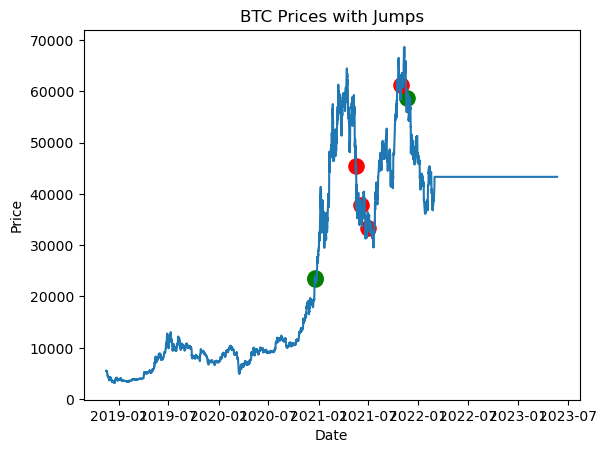

In [208]:
import matplotlib.pyplot as plt

plt.plot(merged_data['date'], merged_data['close'], label='Prices')

jump_indices = final_df[final_df['J'] == 1].index
jump_indices_2 = final_df[final_df['J'] == -1].index
jump_dates = final_df.loc[jump_indices, 'date']
jump_prices = final_df.loc[jump_indices, 'close']
jump_dates_2 = final_df.loc[jump_indices_2, 'date']
jump_prices_2 = final_df.loc[jump_indices_2, 'close']
plt.scatter(jump_dates, jump_prices, color='green', marker='o', s=120, alpha=1, label='Jumps')
plt.scatter(jump_dates_2, jump_prices_2, color='red', marker='o', s=120, alpha=1, label='Jumps')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Prices with Jumps')
plt.show()


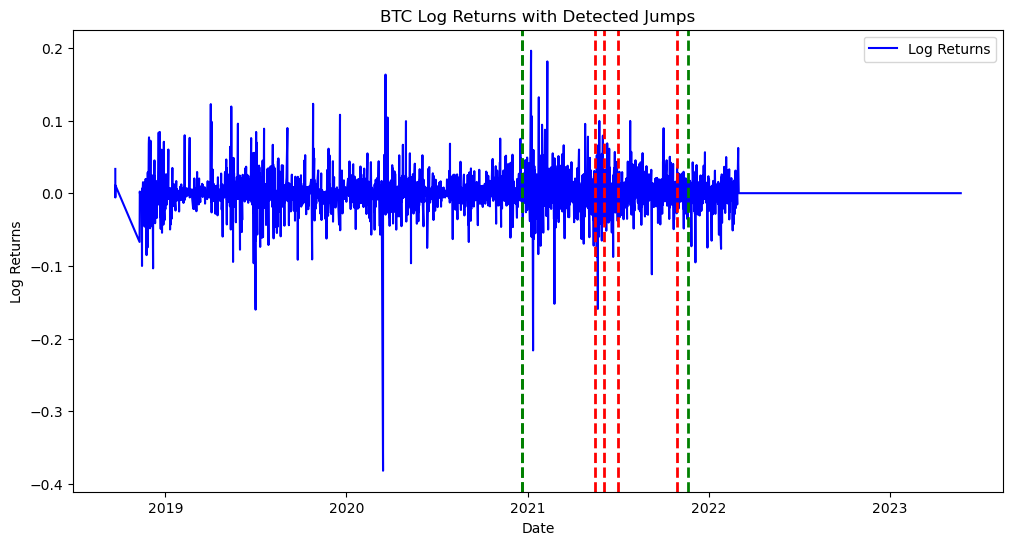

In [209]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged_data_l['date'], merged_data_l['log_return'], color='blue', label='Log Returns')

for index, row in final_df.iterrows():
    if row['J'] == 1:
        plt.axvline(x=row['date'], color='green', linestyle='--', linewidth=2)
    if row['J'] == -1:
        plt.axvline(x=row['date'], color='red', linestyle='--', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('BTC Log Returns with Detected Jumps')

plt.legend()

plt.show()



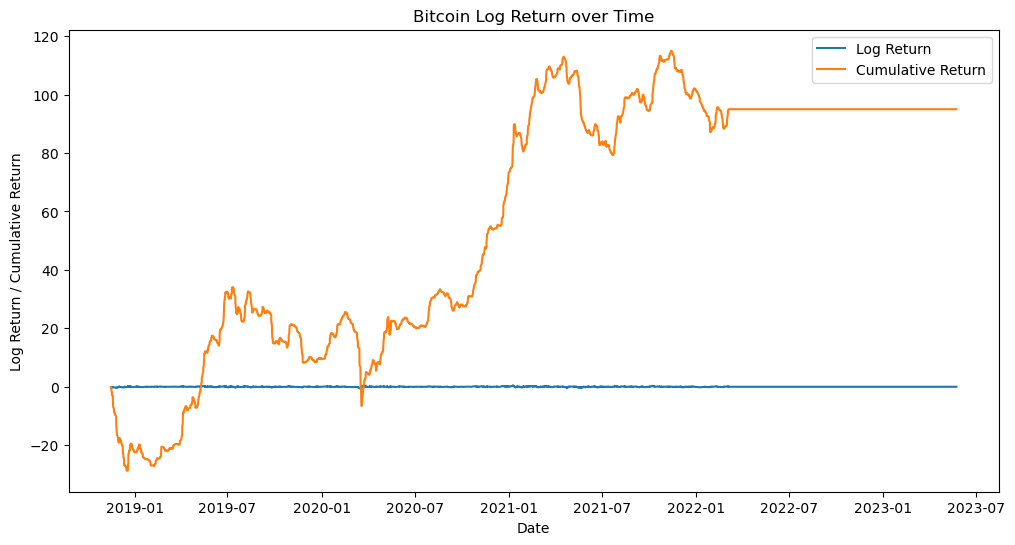

In [210]:
import matplotlib.pyplot as plt

cumulative_returns = merged_data['log_return'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(merged_data['date'], merged_data['log_return'], label='Log Return')
plt.plot(merged_data['date'], cumulative_returns, label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Log Return / Cumulative Return')
plt.title('Bitcoin Log Return over Time')
plt.legend()
plt.show()


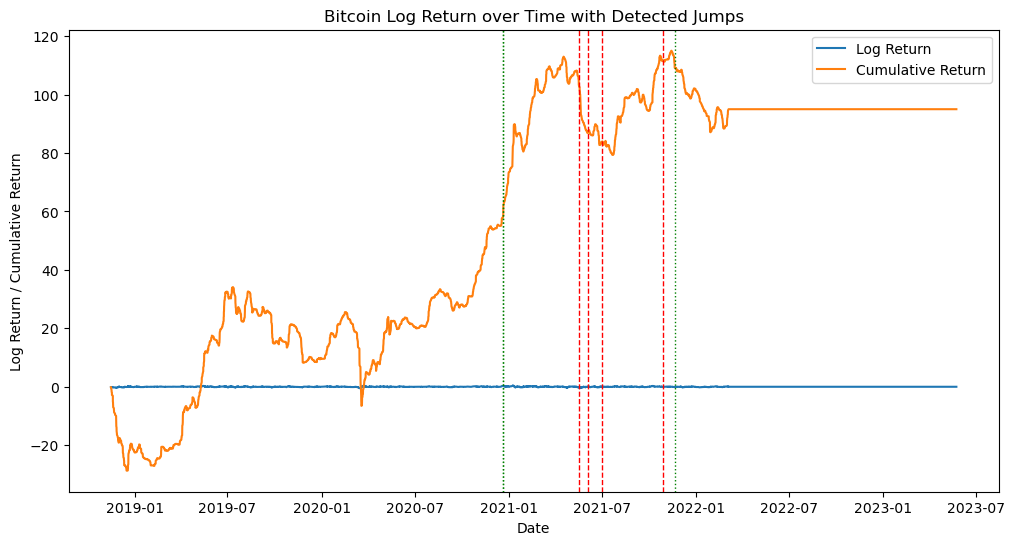

In [211]:
import matplotlib.pyplot as plt

cumulative_returns = merged_data['log_return'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(merged_data['date'], merged_data['log_return'], label='Log Return')
plt.plot(merged_data['date'], cumulative_returns, label='Cumulative Return')
for index, row in final_df.iterrows():
    if row['J'] == 1:
        plt.axvline(x=row['date'], color='green', linestyle='dotted', linewidth=1)
    if row['J'] == -1:
        plt.axvline(x=row['date'], color='red', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Log Return / Cumulative Return')
plt.title('Bitcoin Log Return over Time with Detected Jumps')
plt.legend()
plt.show()


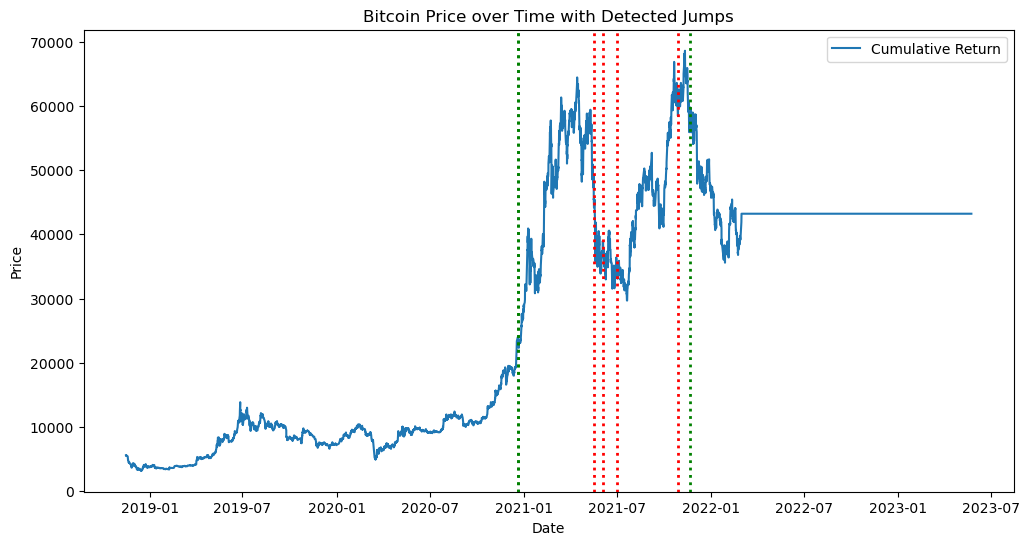

In [212]:
import matplotlib.pyplot as plt

cumulative_returns = merged_data['open']

plt.figure(figsize=(12, 6))
plt.plot(merged_data['date'], cumulative_returns, label='Cumulative Return')
for index, row in final_df.iterrows():
    if row['J'] == 1:
        plt.axvline(x=row['date'], color='green', linestyle='dotted', linewidth=2)
    if row['J'] == -1:
        plt.axvline(x=row['date'], color='red', linestyle='dotted', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price over Time with Detected Jumps')
plt.legend()
plt.show()

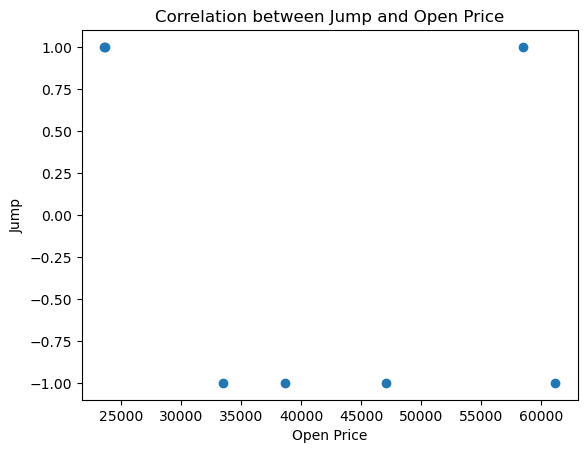

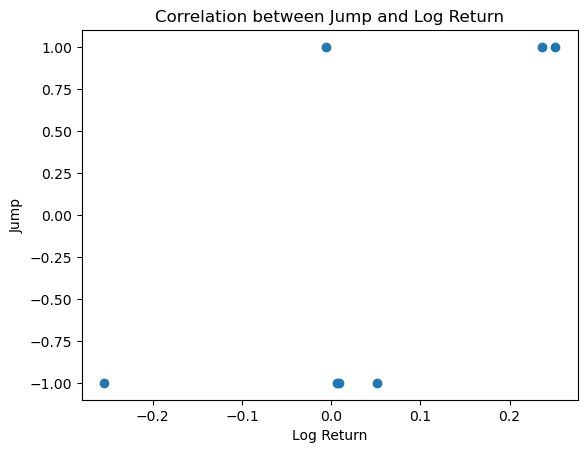

In [213]:
import matplotlib.pyplot as plt

jump_df = final_df[final_df['J'].isin([-1, 1])]

plt.scatter(jump_df['open'], jump_df['J'])
plt.xlabel('Open Price')
plt.ylabel('Jump')
plt.title('Correlation between Jump and Open Price')
plt.show()

plt.scatter(jump_df['log_return'], jump_df['J'])
plt.xlabel('Log Return')
plt.ylabel('Jump')
plt.title('Correlation between Jump and Log Return')
plt.show()


In [278]:
merged_data_d = pd.read_csv("/Users/Admin/Desktop/Elon-Musk-Cryptocurrency-Influence/data_processing/merged_data/final_merged_dataset_dogecoin.csv")
merged_data_d['date'] = pd.to_datetime(merged_data_d['date'])
merged_data_d['log_return'] = np.log(merged_data_d['close'] / merged_data_d['close'].shift(72))

merged_data_d = merged_data_d.dropna()
merged_data_d.head()

,SENDER,MESSAGE,date,is_crypto_related,sentiment_score,sentiment,open,high,low,close,Volume,log_return
1444,-1001153434921,talk enormity cosmos easy toss big number far ...,2019-04-15 03:00:00,False,0.068452,Positive,0.002862,0.002870,0.002850,0.002867,1.885033e+07,0.024361
1445,-1001153434921,winter snowfall beautiful elon musk april,2019-04-15 04:00:00,False,0.850000,Positive,0.002868,0.002882,0.002868,0.002874,2.482680e+07,0.026800
1446,-1001153434921,always crazy twitter fyi elon musk april,2019-04-15 04:00:00,False,-0.600000,Negative,0.002868,0.002882,0.002868,0.002874,2.482680e+07,0.026800
1447,-1001153434921,im actually le crazy person elon musk april,2019-04-15 04:00:00,False,-0.600000,Negative,0.002868,0.002882,0.002868,0.002874,2.482680e+07,0.026800
1448,-1001153434921,haha true actually love horse elon musk april,2019-04-15 04:00:00,False,0.350000,Positive,0.002868,0.002882,0.002868,0.002874,2.482680e+07,0.026800


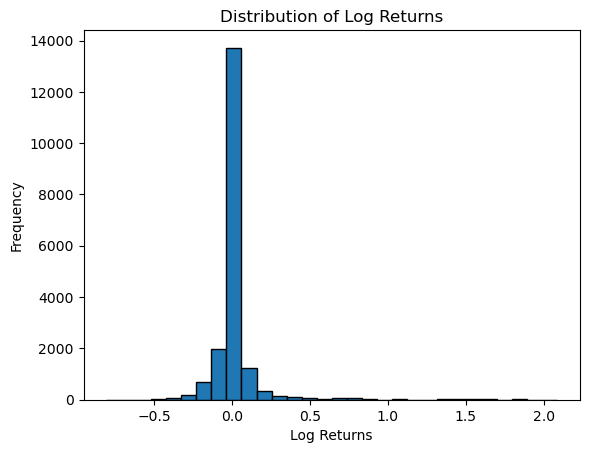

In [279]:
import matplotlib.pyplot as plt

log_returns = merged_data_d['log_return']

plt.hist(log_returns, bins=30, edgecolor='black')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Log Returns')
plt.show()


In [274]:
grouped_data = merged_data_d.groupby('SENDER')
grouped_data.head()

# Mean Bitcoin before and after
hours_before = 48 
hours_after = 48  

mean_prices = []
dates = []

for sender, data in grouped_data:
    tweet_dates = data['date']
    for tweet_date in tweet_dates:
        start_time = tweet_date - pd.Timedelta(hours=hours_before)
        end_time = tweet_date + pd.Timedelta(hours=hours_after)
        prices_before = data[(data['date'] >= start_time) & (data['date'] < tweet_date)]['close']
        prices_after = data[(data['date'] > tweet_date) & (data['date'] <= end_time)]['close']
        mean_before = prices_before.mean()
        mean_after = prices_after.mean()
        mean_prices.append(mean_after - mean_before)
        dates.append(tweet_date)

# new result df
result_df = pd.DataFrame({'date': dates, 'price_change': mean_prices})

# defining threshold for the price movement
threshold = 0.0005
significant_changes = result_df[abs(result_df['price_change']) > threshold]

# falls and jumps
price_jumps = significant_changes[significant_changes['price_change'] > 0]
price_falls = significant_changes[significant_changes['price_change'] < 0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=price_jumps['date'], y=price_jumps['price_change'],
                         mode='markers', marker=dict(color='green'), name='Price jump'))
fig.add_trace(go.Scatter(x=price_falls['date'], y=price_falls['price_change'],
                         mode='markers', marker=dict(color='red'), name='Price fall'))
fig.update_layout(title='Bitcoins price movement after Elon Musks Tweets',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Price Movement'))
fig.show()


In [280]:
from math import ceil, sqrt

def movmean(v, kb, kf):
    """
    Computes the mean with a window of length kb+kf+1 that includes the element 
    in the current position, kb elements backward, and kf elements forward.
    Nonexisting elements at the edges get substituted with NaN.
    Args:
        v (list(float)): List of values.
        kb (int): Number of elements to include before current position
        kf (int): Number of elements to include after current position
    Returns:
        list(float): List of the same size as v containing the mean values
    """
    m = len(v) * [np.nan]
    for i in range(kb, len(v)-kf):
        m[i] = np.mean(v[i-kb:i+kf+1])
    return m


def LeeMykland_d(S, sampling, significance_level=0.1):
    """
    "Jumps in Equilibrium Prices and Market Microstructure Noise"
    - by Suzanne S. Lee and Per A. Mykland
    
    "https://galton.uchicago.edu/~mykland/paperlinks/LeeMykland-2535.pdf"
    
    Args:
        S (list(float)): An array containing prices, where each entry 
                         corresponds to the price sampled every 'sampling' minutes.
        sampling (int): Minutes between entries in S
        significance_level (float): Defaults to 1% (0.001)
        
    Returns:
        A pandas dataframe containing a row covering the interval 
        [t_i, t_i+sampling] containing the following values:
        J:   Binary value is jump with direction (sign)
        L:   L statistics
        T:   Test statistics
        sig: Volatility estimate
    """
    tm = 252*24*60 # Trading minutes
    k   = ceil(sqrt(tm/sampling))
    r = np.append(np.nan, np.diff(np.log(S)))
    bpv = np.multiply(np.absolute(r[:]), np.absolute(np.append(np.nan, r[:-1])))
    bpv = np.append(np.nan, bpv[0:-1]).reshape(-1,1) # Realized bipower variation
    sig = np.sqrt(movmean(bpv, k-3, 0)) # Volatility estimate
    L   = r/sig
    n   = np.size(S) # Length of S
    c   = (2/np.pi)**0.5
    Sn  = c*(2*np.log(n))**0.5
    Cn  = (2*np.log(n))**0.5/c - np.log(np.pi*np.log(n))/(2*c*(2*np.log(n))**0.5)
    beta_star   = -np.log(-np.log(1-significance_level)) # Jump threshold
    T   = (abs(L)-Cn)*Sn
    J   = (T > beta_star).astype(float)
    J   = J*np.sign(r) # Add direction
    # First k rows are NaN involved in bipower variation estimation are set to NaN.
    J[0:k] = np.nan
    # Build and return result dataframe
    return pd.DataFrame({'L': L,'sig': sig, 'T': T,'J':J})

prices = merged_data_d['open'].tolist()

sampling = 60 

result = LeeMykland_d(prices, sampling)

merged_data_d = pd.concat([merged_data_d, result], axis=1)

merged_data_d.head()


/var/folders/49/1bqwbw2539j4jwl3zcbb_hb00000gn/T/ipykernel_56798/3317272405.py:48: RuntimeWarning:

invalid value encountered in true_divide



,SENDER,MESSAGE,date,is_crypto_related,sentiment_score,sentiment,open,high,low,close,Volume,log_return,L,sig,T,J
1444,-1.001153e+12,talk enormity cosmos easy toss big number far ...,2019-04-15 03:00:00,False,0.068452,Positive,0.002862,0.002870,0.002850,0.002867,1.885033e+07,0.024361,0.000000,0.005965,-17.978303,0.0
1445,-1.001153e+12,winter snowfall beautiful elon musk april,2019-04-15 04:00:00,False,0.850000,Positive,0.002868,0.002882,0.002868,0.002874,2.482680e+07,0.026800,0.081740,0.005965,-17.688871,0.0
1446,-1.001153e+12,always crazy twitter fyi elon musk april,2019-04-15 04:00:00,False,-0.600000,Negative,0.002868,0.002882,0.002868,0.002874,2.482680e+07,0.026800,-0.115810,0.005965,-17.568233,-0.0
1447,-1.001153e+12,im actually le crazy person elon musk april,2019-04-15 04:00:00,False,-0.600000,Negative,0.002868,0.002882,0.002868,0.002874,2.482680e+07,0.026800,0.000000,0.005965,-17.978303,0.0
1448,-1.001153e+12,haha true actually love horse elon musk april,2019-04-15 04:00:00,False,0.350000,Positive,0.002868,0.002882,0.002868,0.002874,2.482680e+07,0.026800,-0.833413,0.005965,-15.027296,-0.0


In [281]:
#filtered_df = merged_data[merged_data['J'] == 1]
filtered_df_d = merged_data_d[(merged_data_d['J'] == -1) | (merged_data_d['J'] == 1)]

filtered_df_d.head()

,SENDER,MESSAGE,date,is_crypto_related,sentiment_score,sentiment,open,high,low,close,Volume,log_return,L,sig,T,J
1499,-1.001153e+12,put water repellant coating radar dark rectang...,2019-04-19 23:00:00,False,-0.150000,Negative,0.002853,0.002869,0.002849,0.002857,4.116182e+06,0.010556,8.180781,0.001331,10.988773,1.0
1505,-1.001153e+12,milady shield elon musk april,2019-04-21 00:00:00,False,0.000000,Neutral,0.002812,0.002833,0.002812,0.002831,7.886107e+06,-0.006689,-6.579327,0.001842,5.318233,-1.0
1539,-1.001153e+12,robotaxi probably closer hour accounting empty...,2019-04-23 19:00:00,False,-0.033333,Negative,0.002748,0.002755,0.002744,0.002751,3.899147e+06,-0.052401,9.822566,0.001686,16.802119,1.0
1548,-1.001153e+12,million combustion engine right name car fire ...,2019-04-23 21:00:00,False,0.121429,Positive,0.002740,0.002754,0.002738,0.002741,1.457160e+06,-0.053625,-6.616501,0.001495,5.449860,-1.0
1550,-1.001153e+12,fred every fire investigated problem write inj...,2019-04-23 22:00:00,False,0.002500,Positive,0.002740,0.002740,0.002716,0.002729,2.001750e+06,-0.058013,-10.014475,0.001805,17.481642,-1.0


In [282]:
#final_df = filtered_df[(filtered_df['is_crypto_related'] == True) & (filtered_df['J'] == 1)]
final_df_d = filtered_df_d[(filtered_df_d['is_crypto_related'] == True)]
final_df_d.head()

,SENDER,MESSAGE,date,is_crypto_related,sentiment_score,sentiment,open,high,low,close,Volume,log_return,L,sig,T,J
7922,-1.001153e+12,said btc eth seem high lol elon musk february,2021-02-20 07:00:00,True,0.480000,Positive,0.054359,0.057141,0.054286,0.055392,5.702745e+08,-0.369234,6.017037,0.004331,3.327236,1.0
8591,-1.001153e+12,bitcoin hashing aka mining energy usage starti...,2021-05-20 20:00:00,True,-0.229167,Negative,0.398240,0.406535,0.393450,0.398741,2.059553e+08,-0.222237,-8.777245,0.004828,13.100774,-1.0
8612,-1.001153e+12,please note dogecoin formal organization one r...,2021-05-25 20:00:00,True,0.014286,Positive,0.334548,0.345000,0.333260,0.337665,1.486211e+08,-0.409442,-10.271055,0.008069,18.390159,-1.0


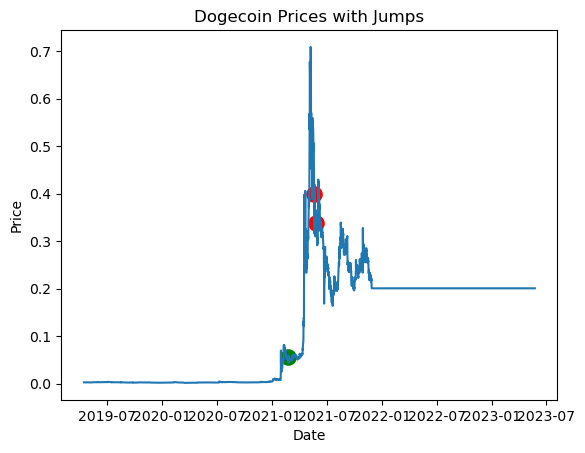

In [283]:
import matplotlib.pyplot as plt

plt.plot(merged_data_d['date'], merged_data_d['close'], label='Prices')

jump_indices_d = final_df_d[final_df_d['J'] == 1].index
jump_indices_2_d = final_df_d[final_df_d['J'] == -1].index
jump_dates_d = final_df_d.loc[jump_indices_d, 'date']
jump_prices_d = final_df_d.loc[jump_indices_d, 'close']
jump_dates_2_d = final_df_d.loc[jump_indices_2_d, 'date']
jump_prices_2_d = final_df_d.loc[jump_indices_2_d, 'close']
plt.scatter(jump_dates_d, jump_prices_d, color='green', marker='o', s=120, alpha=1, label='Jumps')
plt.scatter(jump_dates_2_d, jump_prices_2_d, color='red', marker='o', s=120, alpha=1, label='Jumps')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Dogecoin Prices with Jumps')
plt.show()


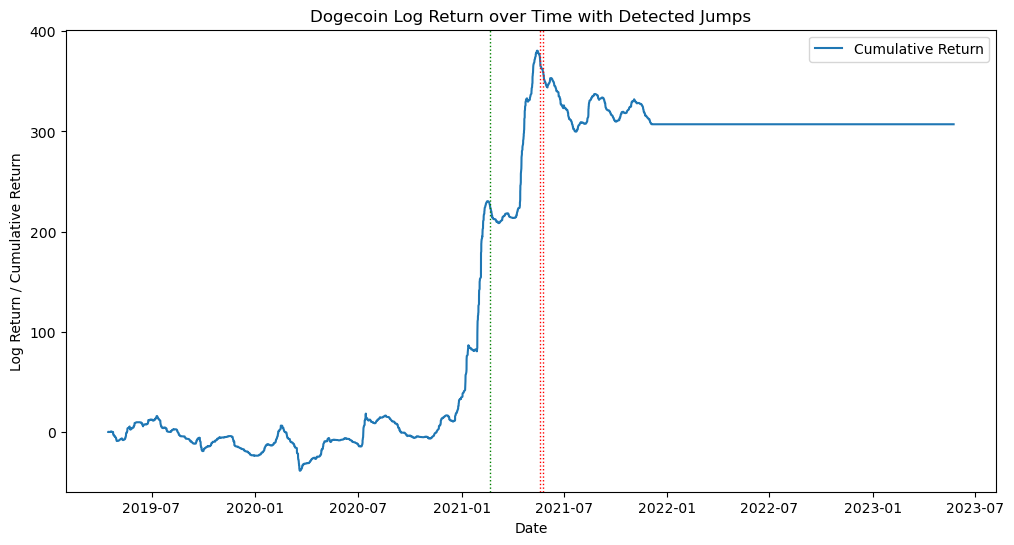

In [284]:
import matplotlib.pyplot as plt

cumulative_returns_d = merged_data_d['log_return'].cumsum()

plt.figure(figsize=(12, 6))
#plt.plot(merged_data_d['date'], merged_data_d['log_return'], label='Log Return')
plt.plot(merged_data_d['date'], cumulative_returns_d, label='Cumulative Return')
for index, row in final_df_d.iterrows():
    if row['J'] == 1:
        plt.axvline(x=row['date'], color='green', linestyle='dotted', linewidth=1)
    if row['J'] == -1:
        plt.axvline(x=row['date'], color='red', linestyle='dotted', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Log Return / Cumulative Return')
plt.title('Dogecoin Log Return over Time with Detected Jumps')
plt.legend()
plt.show()



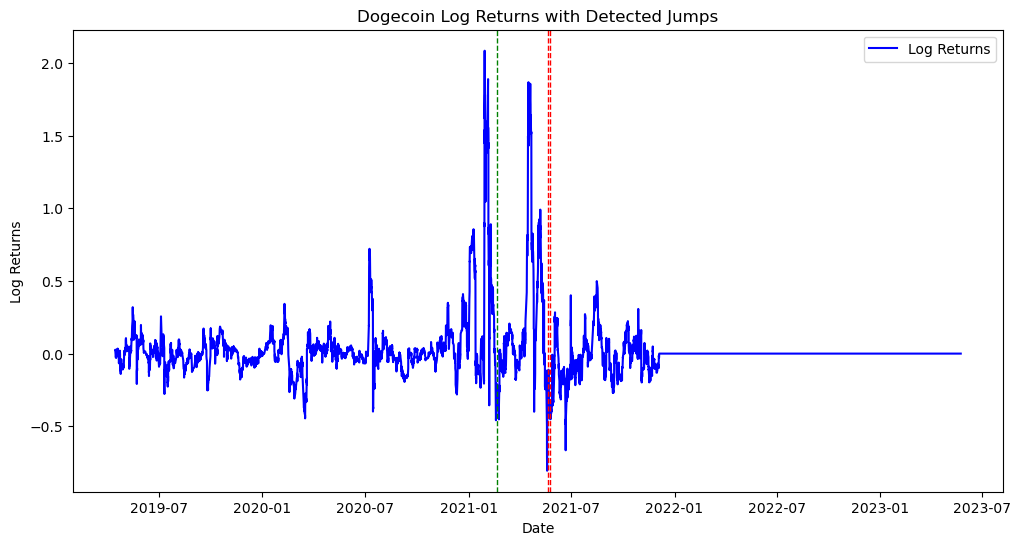

In [286]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged_data_d['date'], merged_data_d['log_return'], color='blue', label='Log Returns')

for index, row in final_df_d.iterrows():
    if row['J'] == 1:
        plt.axvline(x=row['date'], color='green', linestyle='--', linewidth=1)
    if row['J'] == -1:
        plt.axvline(x=row['date'], color='red', linestyle='--', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Dogecoin Log Returns with Detected Jumps')

plt.legend()

plt.show()


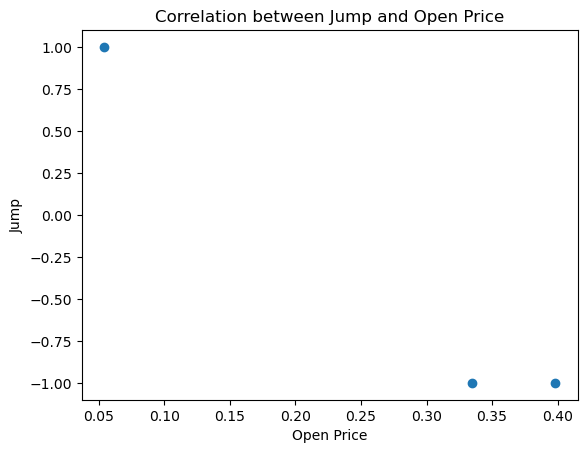

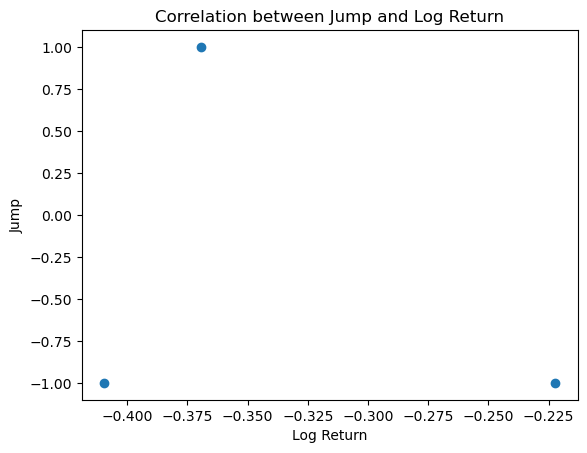

In [287]:
import matplotlib.pyplot as plt

jump_df_d = final_df_d[final_df_d['J'].isin([-1, 1])]

plt.scatter(final_df_d['open'], final_df_d['J'])
plt.xlabel('Open Price')
plt.ylabel('Jump')
plt.title('Correlation between Jump and Open Price')
plt.show()

plt.scatter(jump_df_d['log_return'], jump_df_d['J'])
plt.xlabel('Log Return')
plt.ylabel('Jump')
plt.title('Correlation between Jump and Log Return')
plt.show()
